In [75]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pathlib as pl
import pandas as pd
import sys
import itertools
import geopandas as gpd
import xarray as xr


In [76]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, extentmax, fig_ext, transparent

# Units

In [77]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 25.4
total_key = f"total_{units}"

# Load base MODFLOW base model

In [78]:
ws = "../modflow/pj_2018_adjust_CHDA1/base/"
sim = flopy.mf6.MFSimulation.load(sim_ws=ws, verbosity_level=0)
gwf = sim.get_model()

# Number of GHB cells 
nghb = gwf.ghb.stress_period_data.get_dataframe()[0].shape[0]
nchd = gwf.get_package("chd_coast").stress_period_data.get_dataframe()[0].shape[0]
# Area of one cell
area = 250.0 * 250.0 # note - change to not be hard coded

## Model Grid

In [79]:
mg =gwf.modelgrid
mg_gdf = mg.geo_dataframe 
mg_gdf['row_pj'] = [x[0] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf['col_pj']=  [x[1] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf.set_crs(epsg = 4456, inplace=True)
print(mg_gdf.crs)


EPSG:4456


In [80]:

path = pl.Path('../modflow/pj_2018_adjust_CHDA1/base/external')
lay_arr = np.array([np.loadtxt(path / 'top.dat')] + [np.loadtxt(file) for file in sorted(path.glob('bot*.dat'))])

## Time and SP

In [81]:
tdis = sim.tdis
mf_startdate = tdis.start_date_time.array
mf_perioddata= tdis.perioddata.array
# calculate date for each stress period
mf_SPdates = [pd.to_datetime(mf_startdate)]
for perlen, nstp, tsmult in mf_perioddata:
    mf_SPdates.append(mf_SPdates[-1] + pd.Timedelta(days = perlen))
# remove the last date because it is extra
mf_SPdates = mf_SPdates[:-1]

# Compute cumulative total times at the end of each stress period
mf_totaltimes= tdis.perioddata.array['perlen'].cumsum()

mf_tdis_df = pd.DataFrame({'Date':mf_SPdates,
                           'SP': list(mf_perioddata),
                           'totim': mf_totaltimes})

## Sim Directories

In [82]:
#sim_dirs = ["run_01.00D", "run_08.00H", "run_04.00H", "run_02.00H", "run_01.00H", "run_15.00M"]
sim_dirs = ['run_NoAtm_01.00H', 'run_NoAtm_02.00H']
sim_dirs_atm = ['run_01.00H', 'run_02.00H']

# Coastal Exchange

In [83]:
chd_coastal_df = pl.Path(ws) /'external' /'chd_coastal.dat'
chd_coastal_df = pd.read_csv(chd_coastal_df, sep=' ', names = ['lay','row','col','bhead','salinity','bname'])
# Identify perimeter coastal cells that will be removed from coastal flux analysis
perim_coastal = chd_coastal_df.loc[chd_coastal_df['bname'] == 'surface perimeter coastal']
perim_coastal[['lay','row','col']] -=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\2154863800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perim_coastal[['lay','row','col']] -=1


Figure Settings

In [84]:
ws = pl.Path("figures")
ws.mkdir(exist_ok=True, parents=True)

In [85]:
# Create labels
# ===================
labels = [value.split(sep="m_")[1] for value in sim_dirs]

for idx, label in enumerate(labels):
    s = f"{float(label[:5]):>2.0f}" + " " + label[-1]
    if s.endswith(" D"):
        s = s.replace(" D", " Day ")
    elif s.endswith(" H"):
        s = s.replace(" H", " Hour")
    elif s.endswith(" M"):
        s = s.replace(" M", " Min.")
    labels[idx] = s    
labels

[' 1 Hour', ' 2 Hour']

In [86]:
line_styles = ["-", "--", "-.", ":", (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]

In [87]:
colors = [value for key, value in mcolors.TABLEAU_COLORS.items()]

## GHB Obs

In [88]:
sim = sim_dirs[0]
# GHB Obs Cells
# #=====================================================
ghb_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\{sim}\gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])
ghb_obs_cells['cellid'] = ghb_obs_cells['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
ghb_obs_cells[['lay', 'row', 'col']] = ghb_obs_cells['cellid'].str.split(',', expand=True)
ghb_obs_cells = ghb_obs_cells.iloc[:-1]
ghb_obs_cells[['lay', 'row', 'col']] = ghb_obs_cells[['lay', 'row', 'col']].astype(int)
ghb_obs_cells[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3193539917.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ghb_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\{sim}\gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])


In [89]:
sim_dict_GHB = {value: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{value}")} for value in sim_dirs}

In [90]:
for key, value in sim_dict_GHB.items():
    obs_path = value["ws"] / "outputs" /"GHB_obs.csv"
    print(obs_path)
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    # Calculate the length of each timestep
    df["delt"] = df["totim"].diff()
    # Replace the first rows time step length because it will be nan
    df.loc[df["delt"].isnull(), "delt"] = df["delt"].iloc[1]
    # remove total time column
    df.drop("totim", axis=1, inplace=True)
    df["TOTAL_ft^3"] = 0.0
    df['TOTAL_ft'] = 0.0
    df["TOTAL_mm"] = 0.0


    # Convert values from ft^3 to mm , and create total column that sums all GHB cells
    for col_name in df.columns: 
        df['TOTAL_ft^3'] +=  df[col_name] 
        # speficic discharge
        df['TOTAL_ft'] = df['TOTAL_ft^3'] /(nghb*area)
        # ft^3 to mm
        df["TOTAL_mm"] += (conversion_factor * 12.0 * df[col_name])  /(nghb*area)

    # cumulative sum
    df["CUM_TOTAL_ft"] = df['TOTAL_ft'].cumsum() * df['delt']
    df["CUM_TOTAL_mm"] = df["TOTAL_mm"].cumsum() * df['delt']

    df["ZERO"] = 0.
    df.drop("delt", axis=1, inplace=True)
    # number of timesteps
    sim_dict_GHB[key]["ntimes"] = df.shape[0]
    # store DF
    sim_dict_GHB[key]["df"] = df.copy()
    # Final cumulative total 
    sim_dict_GHB[key][total_key] = df["CUM_TOTAL_ft"].iloc[-1]

..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_02.00H\outputs\GHB_obs.csv


In [91]:
cum_labels_GHB = []
for idx, value in enumerate(sim_dirs):
    total_flux = sim_dict_GHB[value][total_key]
    cum_labels_GHB.append(f"{labels[idx]} ({total_flux:5.2f} ft)")
cum_labels_GHB

[' 1 Hour (-27.57 ft)', ' 2 Hour (-27.58 ft)']

## CHD Obs

In [92]:
# CHD Obs Cells
# #=====================================================
chd_coastal_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])
# Replace *any* whitespace in cellid with commas
chd_coastal_obs_cells['cellid'] = chd_coastal_obs_cells['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
chd_coastal_obs_cells[['lay', 'row', 'col']] = chd_coastal_obs_cells['cellid'].str.split(',', expand=True)
chd_coastal_obs_cells = chd_coastal_obs_cells.iloc[:-1]
chd_coastal_obs_cells[['lay', 'row', 'col']] = chd_coastal_obs_cells[['lay', 'row', 'col']].astype(int)
chd_coastal_obs_cells[['lay', 'row', 'col']]-=1

# Save observations for all simulations
# ======================================
chd_obs_dict = {}
for sim in sim_dirs+sim_dirs_atm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\chd_coastal_obs.csv'
    print(f'loading:{obs_path}')
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    # Initialize total columns
    for col in ["TOTAL_ft^3", "TOTAL_ft", "TOTAL_mm", "CUM_TOTAL_ft", "CUM_TOTAL_mm", "ZERO"]:
        df[col] = 0.0
    # Calculate timestep length safely
    df["delt"] = df["totim"].diff().fillna(method="bfill")
    df.drop("totim", axis=1, inplace=True)
    chd_obs_dict[sim] = df

# Split up obs cells based on how you want to analyze them
#-===================================================
# all CHDs on the surface
coastal_surface_cells = chd_coastal_obs_cells[chd_coastal_obs_cells['lay'] == 0]
# all perimeter CHDs on the coast
coastal_allperimetercells  = chd_coastal_obs_cells[chd_coastal_obs_cells['chd_name'].str.contains('perimeter')]
# perimeter CHDs on the coast that are not in layer 1
coastal_depth_cells = chd_coastal_obs_cells[chd_coastal_obs_cells['lay'] != 0]

# Determine the observation names in order to drop column names later
depth_names_upper = set(chd_coastal_obs_cells.loc[coastal_depth_cells.index, 'chd_name'].str.upper().str.replace("'", ""))
surface_names_upper = set(chd_coastal_obs_cells.loc[coastal_surface_cells.index, 'chd_name'].str.upper().str.replace("'", ""))
perimeter_names_upper = set(chd_coastal_obs_cells.loc[coastal_allperimetercells.index, 'chd_name'].str.upper().str.replace("'", ""))

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3919500702.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  chd_coastal_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])


loading:..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3919500702.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_02.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3919500702.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_01.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3919500702.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_02.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\3919500702.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


### Atmoshphere

In [93]:
# Define total_key
total_key = "TOTAL_CUM_ft"

# ---------------- Prepare dictionaries ----------------
coastal_surface_obs_dict_ATM = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs_atm}
coastal_surface_noperim_obs_dict_ATM = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs_atm}
coastal_depth_obs_dict_ATM = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs_atm}

# Columns to exclude from totals
total_ignore_cols = ["delt", "TOTAL_ft^3", "TOTAL_ft", "TOTAL_mm", "CUM_TOTAL_ft", "CUM_TOTAL_mm", "ZERO"]

# ---------------- Process each simulation ----------------
for sim in sim_dirs_atm:
    print(sim)
    df = chd_obs_dict[sim]
    # ---------- Surface Coastal Observations ----------
    coastal_surface_obs = df.drop(columns=depth_names_upper, errors='ignore')
    obs_cols = [c for c in coastal_surface_obs.columns if c not in total_ignore_cols]

    # Vectorized totals
    coastal_surface_obs['TOTAL_ft^3'] = coastal_surface_obs[obs_cols].sum(axis=1)
    coastal_surface_obs['TOTAL_mm'] = (coastal_surface_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_surface_obs['TOTAL_ft'] = coastal_surface_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_surface_obs['CUM_TOTAL_ft'] = (coastal_surface_obs['TOTAL_ft'] * coastal_surface_obs['delt']).cumsum()
    coastal_surface_obs['CUM_TOTAL_mm'] = (coastal_surface_obs['TOTAL_mm'] * coastal_surface_obs['delt']).cumsum()

    # Save
    coastal_surface_obs_dict_ATM[sim]["df"] = coastal_surface_obs
    coastal_surface_obs_dict_ATM[sim]["ntimes"] = coastal_surface_obs.shape[0]
    coastal_surface_obs_dict_ATM[sim][total_key] = coastal_surface_obs['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Surface Coastal Observations - No Perimeter ----------
    drop_cols = depth_names_upper.union(perimeter_names_upper)
    coastal_surfaceNoPerim_obs = df.drop(columns=drop_cols, errors='ignore')
    obs_cols = [c for c in coastal_surfaceNoPerim_obs.columns if c not in total_ignore_cols]

    coastal_surfaceNoPerim_obs['TOTAL_ft^3'] = coastal_surfaceNoPerim_obs[obs_cols].sum(axis=1)
    coastal_surfaceNoPerim_obs['TOTAL_mm'] = (coastal_surfaceNoPerim_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_surfaceNoPerim_obs['TOTAL_ft'] = coastal_surfaceNoPerim_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_surfaceNoPerim_obs['CUM_TOTAL_ft'] = (coastal_surfaceNoPerim_obs['TOTAL_ft'] * coastal_surfaceNoPerim_obs['delt']).cumsum()
    coastal_surfaceNoPerim_obs['CUM_TOTAL_mm'] = (coastal_surfaceNoPerim_obs['TOTAL_mm'] * coastal_surfaceNoPerim_obs['delt']).cumsum()

    coastal_surface_noperim_obs_dict_ATM[sim]["df"] = coastal_surfaceNoPerim_obs
    coastal_surface_noperim_obs_dict_ATM[sim]["ntimes"] = coastal_surfaceNoPerim_obs.shape[0]
    coastal_surface_noperim_obs_dict_ATM[sim][total_key] = coastal_surfaceNoPerim_obs['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Depth Coastal Observations ----------
    coastal_depth_obs = df.drop(columns=surface_names_upper, errors='ignore')
    obs_cols = [c for c in coastal_depth_obs.columns if c not in total_ignore_cols]

    coastal_depth_obs['TOTAL_ft^3'] = coastal_depth_obs[obs_cols].sum(axis=1)
    coastal_depth_obs['TOTAL_mm'] = (coastal_depth_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_depth_obs['TOTAL_ft'] = coastal_depth_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_depth_obs['CUM_TOTAL_ft'] = (coastal_depth_obs['TOTAL_ft'] * coastal_depth_obs['delt']).cumsum()
    coastal_depth_obs['CUM_TOTAL_mm'] = (coastal_depth_obs['TOTAL_mm'] * coastal_depth_obs['delt']).cumsum()

    coastal_depth_obs_dict_ATM[sim]["df"] = coastal_depth_obs
    coastal_depth_obs_dict_ATM[sim]["ntimes"] = coastal_depth_obs.shape[0]
    coastal_depth_obs_dict_ATM[sim][total_key] = coastal_depth_obs['CUM_TOTAL_ft'].iloc[-1]

    print(f"Saved DataFrames for {sim} successfully.\n")


run_01.00H
Saved DataFrames for run_01.00H successfully.

run_02.00H
Saved DataFrames for run_02.00H successfully.



### No atmosphere

coastal surface observation cells are all the bay cells + perimeter cells in bay in layer 0

coastal depth observations are all the perimeter cells in the bay in layers > 0

In [94]:
# Define total_key
total_key = "TOTAL_CUM_ft"

# ---------------- Prepare dictionaries ----------------
coastal_surface_obs_dict  = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs }
coastal_surface_noperim_obs_dict  = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs }
coastal_depth_obs_dict  = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in sim_dirs }

# Columns to exclude from totals
total_ignore_cols = ["delt", "TOTAL_ft^3", "TOTAL_ft", "TOTAL_mm", "CUM_TOTAL_ft", "CUM_TOTAL_mm", "ZERO"]

# ---------------- Process each simulation ----------------
for sim in sim_dirs :
    print(sim)
    df = chd_obs_dict[sim]
    # ---------- Surface Coastal Observations ----------
    coastal_surface_obs = df.drop(columns=depth_names_upper, errors='ignore')
    obs_cols = [c for c in coastal_surface_obs.columns if c not in total_ignore_cols]

    # Vectorized totals
    coastal_surface_obs['TOTAL_ft^3'] = coastal_surface_obs[obs_cols].sum(axis=1)
    coastal_surface_obs['TOTAL_mm'] = (coastal_surface_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_surface_obs['TOTAL_ft'] = coastal_surface_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_surface_obs['CUM_TOTAL_ft'] = (coastal_surface_obs['TOTAL_ft'] * coastal_surface_obs['delt']).cumsum()
    coastal_surface_obs['CUM_TOTAL_mm'] = (coastal_surface_obs['TOTAL_mm'] * coastal_surface_obs['delt']).cumsum()

    # Save
    coastal_surface_obs_dict [sim]["df"] = coastal_surface_obs
    coastal_surface_obs_dict [sim]["ntimes"] = coastal_surface_obs.shape[0]
    coastal_surface_obs_dict [sim][total_key] = coastal_surface_obs['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Surface Coastal Observations - No Perimeter ----------
    drop_cols = depth_names_upper.union(perimeter_names_upper)
    coastal_surfaceNoPerim_obs = df.drop(columns=drop_cols, errors='ignore')
    obs_cols = [c for c in coastal_surfaceNoPerim_obs.columns if c not in total_ignore_cols]

    coastal_surfaceNoPerim_obs['TOTAL_ft^3'] = coastal_surfaceNoPerim_obs[obs_cols].sum(axis=1)
    coastal_surfaceNoPerim_obs['TOTAL_mm'] = (coastal_surfaceNoPerim_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_surfaceNoPerim_obs['TOTAL_ft'] = coastal_surfaceNoPerim_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_surfaceNoPerim_obs['CUM_TOTAL_ft'] = (coastal_surfaceNoPerim_obs['TOTAL_ft'] * coastal_surfaceNoPerim_obs['delt']).cumsum()
    coastal_surfaceNoPerim_obs['CUM_TOTAL_mm'] = (coastal_surfaceNoPerim_obs['TOTAL_mm'] * coastal_surfaceNoPerim_obs['delt']).cumsum()

    coastal_surface_noperim_obs_dict [sim]["df"] = coastal_surfaceNoPerim_obs
    coastal_surface_noperim_obs_dict [sim]["ntimes"] = coastal_surfaceNoPerim_obs.shape[0]
    coastal_surface_noperim_obs_dict [sim][total_key] = coastal_surfaceNoPerim_obs['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Depth Coastal Observations ----------
    coastal_depth_obs = df.drop(columns=surface_names_upper, errors='ignore')
    obs_cols = [c for c in coastal_depth_obs.columns if c not in total_ignore_cols]

    coastal_depth_obs['TOTAL_ft^3'] = coastal_depth_obs[obs_cols].sum(axis=1)
    coastal_depth_obs['TOTAL_mm'] = (coastal_depth_obs[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    coastal_depth_obs['TOTAL_ft'] = coastal_depth_obs['TOTAL_ft^3'] / (nchd * area)
    coastal_depth_obs['CUM_TOTAL_ft'] = (coastal_depth_obs['TOTAL_ft'] * coastal_depth_obs['delt']).cumsum()
    coastal_depth_obs['CUM_TOTAL_mm'] = (coastal_depth_obs['TOTAL_mm'] * coastal_depth_obs['delt']).cumsum()

    coastal_depth_obs_dict [sim]["df"] = coastal_depth_obs
    coastal_depth_obs_dict [sim]["ntimes"] = coastal_depth_obs.shape[0]
    coastal_depth_obs_dict [sim][total_key] = coastal_depth_obs['CUM_TOTAL_ft'].iloc[-1]

    print(f"Saved DataFrames for {sim} successfully.\n")


run_NoAtm_01.00H
Saved DataFrames for run_NoAtm_01.00H successfully.

run_NoAtm_02.00H
Saved DataFrames for run_NoAtm_02.00H successfully.



## Figure

### dflow versions

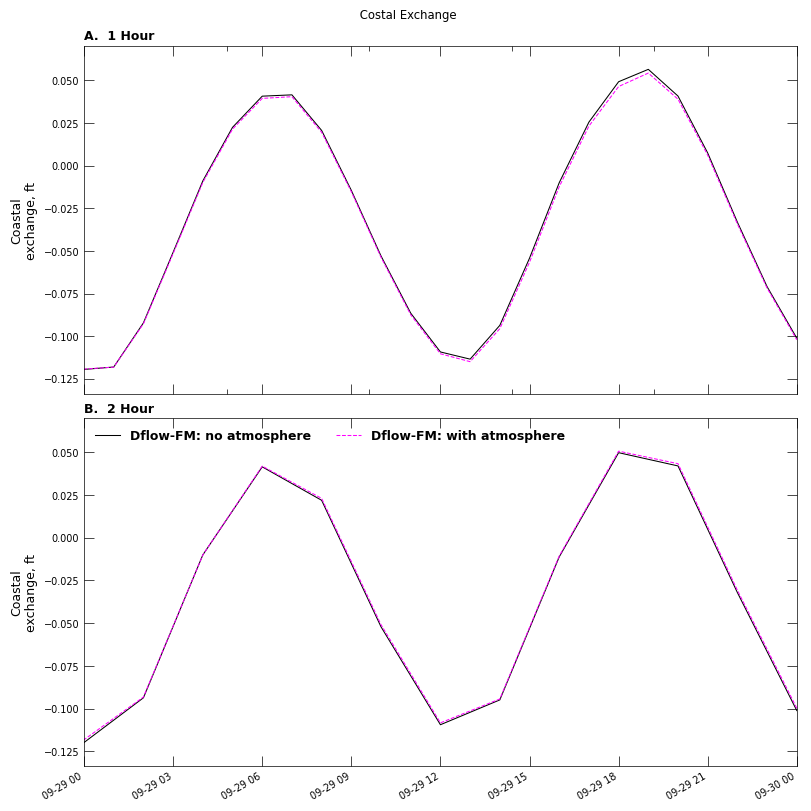

In [95]:
#=================================================================
start_date = pd.Timestamp('2018-09-29 00:00:00')

with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels),
        layout="constrained",
        figsize=(8,8),
        )
    for idx in range(len(sim_dirs)):
        ax = axs[idx]
        df_chd = coastal_surface_noperim_obs_dict[sim_dirs[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='black', sharex=True, label ="Dflow-FM: no atmosphere")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        df_chd = coastal_surface_noperim_obs_dict_ATM[sim_dirs_atm[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="--", color='magenta', sharex=True, label ="Dflow-FM: with atmosphere")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        ax.set_ylabel(f"Coastal\nexchange, ft")
        ax.set_xlabel("")
        ax.set_xlim(start_date, df.index[-1])
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx])

    ax = axs[-1]

    #ax.set_ylim(0, 15 * conversion_factor)
    
    # for idx, value in enumerate(sim_dirs):
    #     sim_dict_GHB[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, ls=line_styles[idx], color=colors[idx], label=cum_labels[idx])
    # ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    # ax.set_xlim(start_date, df_ghb.index[-1])
    # ax.set_xlabel("")
    # flopy.plot.styles.heading(ax, idx=len(labels), heading="Cumulative")
    fig.suptitle(' Costal Exchange')
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)


### Coastal Exchange time series

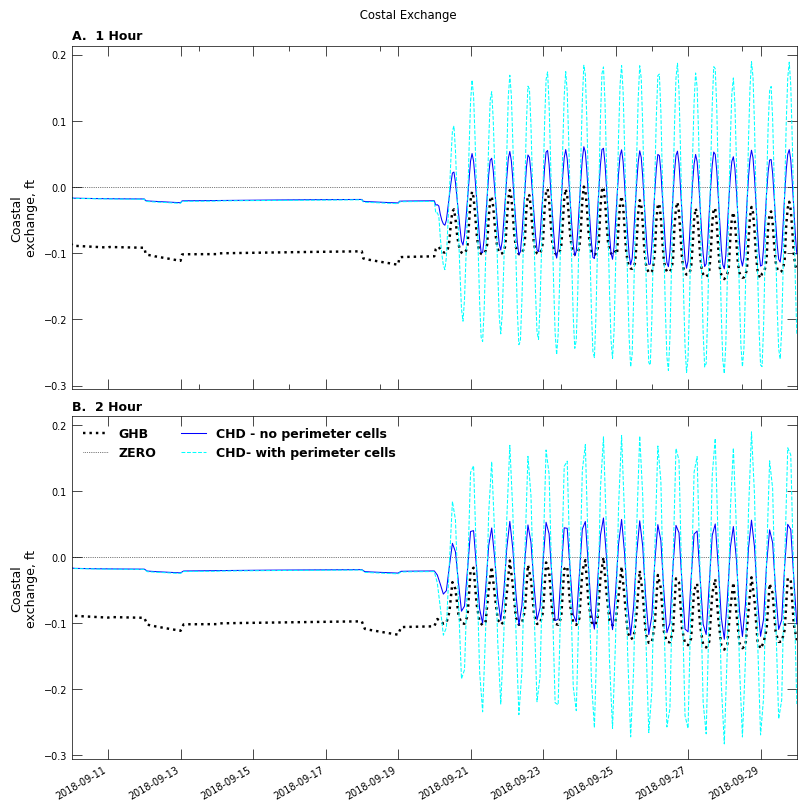

In [96]:
#=================================================================
start_date = pd.Timestamp('2018-09-10 00:00:00')

with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels),
        layout="constrained",
        figsize=(8,8),
        )
    for idx in range(len(sim_dirs)):
        ax = axs[idx]
       # ax.set_ylim(-1 * conversion_factor, 1 * conversion_factor)
        df_ghb = sim_dict_GHB[sim_dirs[idx]]["df"]
        df_ghb["TOTAL_ft"].plot(ax=ax, lw=1.75, ls=":", color='black',sharex=True, label= "GHB")
        df_ghb["ZERO"].plot(ax=ax, lw=0.5, ls=":", color="black", sharex=True)
        
        df_chd = coastal_surface_noperim_obs_dict[sim_dirs[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='blue', sharex=True, label ="CHD - no perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        df_chd = coastal_surface_obs_dict[sim_dirs[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="--", color='cyan', sharex=True, label ="CHD- with perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        ax.set_ylabel(f"Coastal\nexchange, ft")
        ax.set_xlabel("")
        ax.set_xlim(start_date, df_ghb.index[-1])
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx])

    ax = axs[-1]

    #ax.set_ylim(0, 15 * conversion_factor)
    
    # for idx, value in enumerate(sim_dirs):
    #     sim_dict_GHB[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, ls=line_styles[idx], color=colors[idx], label=cum_labels[idx])
    # ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    # ax.set_xlim(start_date, df_ghb.index[-1])
    # ax.set_xlabel("")
    # flopy.plot.styles.heading(ax, idx=len(labels), heading="Cumulative")
    fig.suptitle(' Costal Exchange')
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)


### Coastal Exchange Map

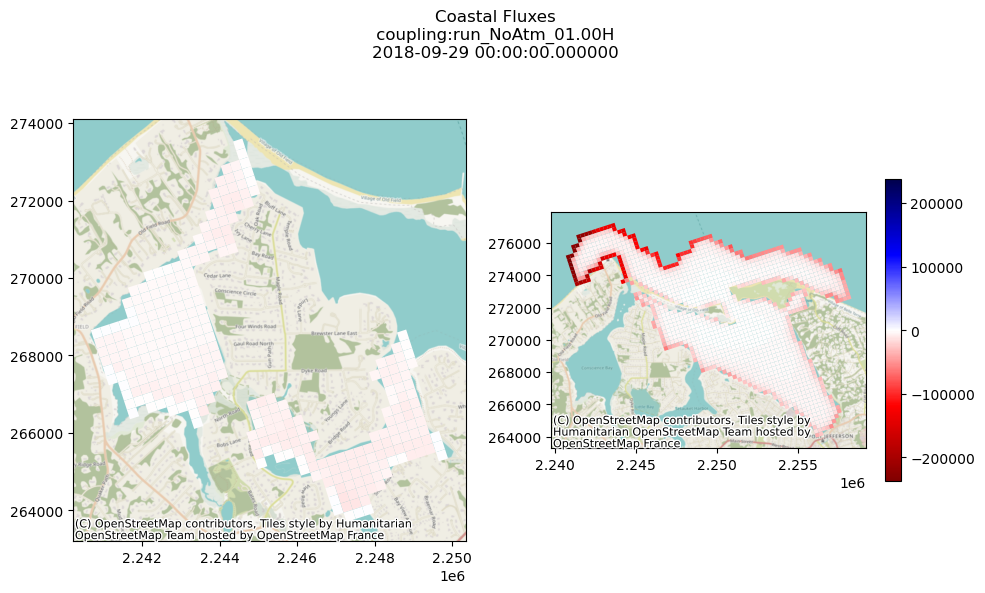

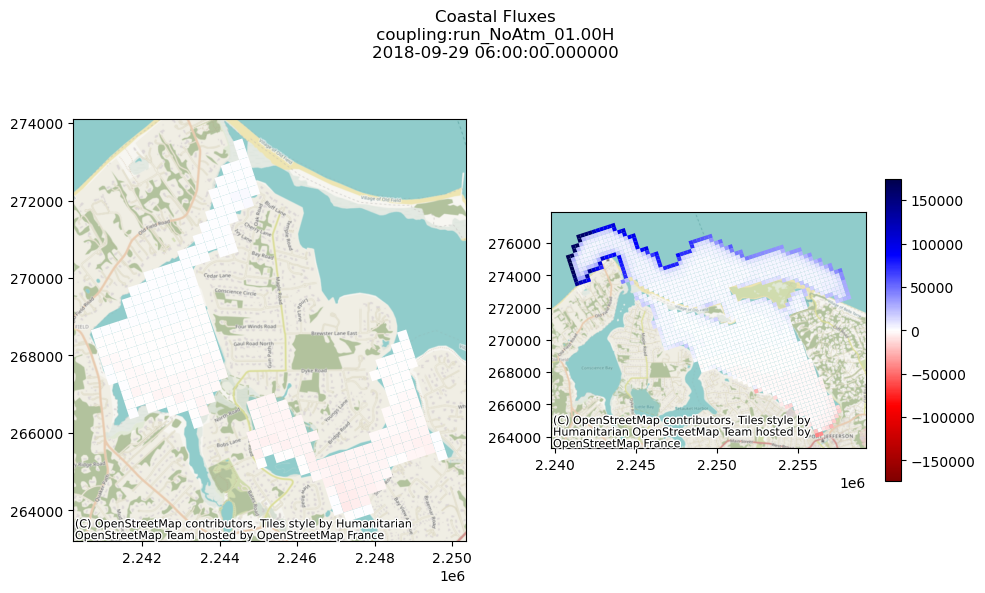

In [97]:
sim = sim_dirs[0]
datetimes  = "2018-09-29 00:00:00.000000" ,  "2018-09-29 06:00:00.000000"

for datetime in datetimes:
    # GHB 
    # ==========
    #Populate map with GHB values
    mg_ghb = mg_gdf.copy()
    mg_ghb['ghb_flux'] = float(0)
    #Populate map with GHB values
    for r,c in zip(ghb_obs_cells['row'], ghb_obs_cells['col']):
        # identify the ghb cell name from the row,col
        name = ghb_obs_cells.loc[((ghb_obs_cells['row'] == r) & (ghb_obs_cells['col'] == c)), 'ghb_name'].iloc[0]
        # use the ghb name to correctly index the observation results
        mg_ghb.loc[((mg_ghb['row_pj'] == r) & (mg_ghb['col_pj'] == c)),'ghb_flux'] = sim_dict_GHB[sim]['df'][name.upper()].loc[datetime]

    #CHD
    #===========
    #Populate map with CHD values
    mg_chd = mg_gdf.copy()
    mg_chd['chd_flux'] =float(0)
    for r,c in zip(coastal_surface_cells['row'], coastal_surface_cells['col']):
        # identify the ghb cell name from the row,col
        name = coastal_surface_cells.loc[((coastal_surface_cells['row'] == r) & (coastal_surface_cells['col'] == c)), 'chd_name'].iloc[0]
        # use the ghb name to correctly index the observation results
        name = name.upper().replace("'","")
        mg_chd.loc[((mg_chd['row_pj'] == r) & (mg_chd['col_pj'] == c)),'chd_flux'] = coastal_surface_obs_dict[sim]['df'][name.upper()].loc[datetime]

    #Figure
    #---------
    fig, ax = plt.subplots(1,2, figsize = (10,6))
    vmin = mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].min()
    vmax =  mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].max()
    absmax = max(abs(vmin),abs(vmax))
    #vmax = 0
    mg_ghb[mg_ghb['ghb_flux']!=0].plot(column = 'ghb_flux', cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[0], legend_kwds={'shrink': 0.6}) # shrink colorbar to 60% of axis height
    cx.add_basemap(ax=ax[0], crs=mg_ghb.crs)
    mg_chd[mg_chd['chd_flux']!=0].plot(column = 'chd_flux', legend=True, cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[1] ,legend_kwds={'shrink': 0.6})  # shrink colorbar to 60% of axis height
    cx.add_basemap(ax=ax[1], crs=mg_ghb.crs)
    fig.suptitle(f'Coastal Fluxes\n coupling:{sim} \n{datetime}')
    fig.tight_layout()   
    plt.show()



# Head Observations

In [98]:
# GWF Obs Cells
# #=====================================================
gwf_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])
# Replace *any* whitespace in cellid with commas
gwf_obs_cells['cellid'] = gwf_obs_cells['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
gwf_obs_cells[['lay', 'row', 'col']] = gwf_obs_cells['cellid'].str.split(',', expand=True)
gwf_obs_cells = gwf_obs_cells.iloc[:-1]
gwf_obs_cells[['lay', 'row', 'col']] = gwf_obs_cells[['lay', 'row', 'col']].astype(int)
gwf_obs_cells[['lay', 'row', 'col']]-=1

# GWF Obs 
#=========
headobs_dict = {}
for sim in sim_dirs+sim_dirs_atm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\hd_obs.csv'
    print(obs_path)
    #df = flopy.utils.Mf6Obs(obs_path).get_dataframe()  
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    headobs_dict[sim] = df

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_32828\4236082489.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  gwf_obs_cells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])


..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_02.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_01.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_02.00H\outputs\hd_obs.csv


## Observed vs. Simulated in PJ

EPSG:4456


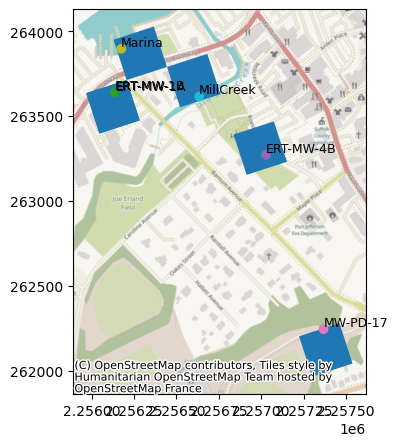

In [99]:
pj_network = gpd.read_file("../../../GIS/PJ_mininetwork_2024/PJ_mininetwork_withsensors.shp")
pj_network.to_crs(epsg=4456,inplace=True)
print(pj_network.crs)
# 'screen_top' is the depth to the screen from the casing 
# 'casing_top' is in reference to ft above msl
# calculate 'screen_top_msl' which is in reference to sea-level, by su
pj_network['screen_top_msl'] = pj_network['casing_top']- pj_network['screen_top']
# Determine where the wells intersect the model grid
pj_network_modelcells = gpd.sjoin(mg_gdf,pj_network,how = 'inner', predicate='intersects')
# # Explore
# a = pj_network_modelcells.explore()
# b = pj_network.explore(m=a)

# MAP OF PJ MONITORING SITES
# =========================
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the points with legend
pj_network_modelcells.plot(ax=ax)
pj_network.plot(column='Site',  ax=ax)
cx.add_basemap(ax, crs=pj_network.crs)
for idx, row in pj_network.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row['Site']  # Change to another column if preferred
    ax.text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
plt.show()


# IMPORT AND SAVE PJ WATER LEVEL OBSERVATIONS
# =================================================
from pathlib import Path

lai_dict = {}

# GROUNDWATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/gw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    f['Date/Time'] = pd.to_datetime(f['Date/Time'])
    lai_dict[file.name[:-4]] = f
# SURFACE WATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/sw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    lai_dict[file.name[:-4]] = f
    f['Time'] = pd.to_datetime(f['Time'])


ERT-MW-1A: screen top elevation =-35.67, layer=6, layer_val=-26.9
ERT-MW-1B: screen top elevation =-60.62, layer=7, layer_val=-82.23
ERT-MW-4B: screen top elevation =-112.21, layer=7, layer_val=-97.2
MW-PD-17: screen top elevation =-55.260000000000005, layer=6, layer_val=-49.37


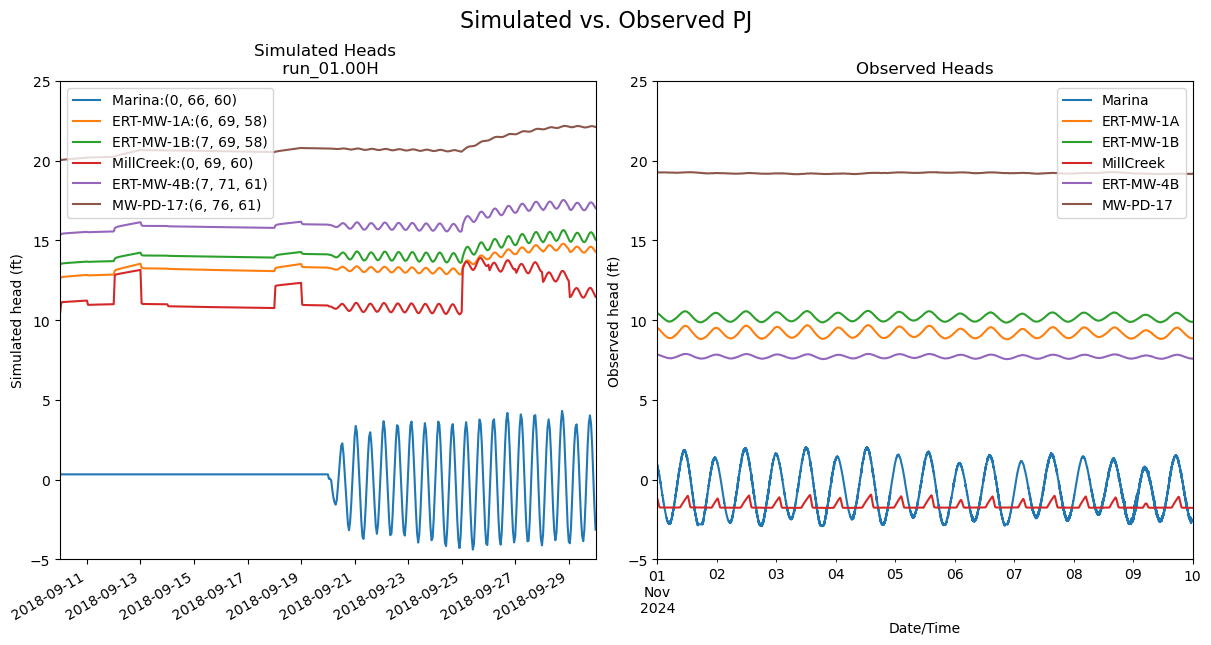

In [107]:
sim = sim_dirs_atm[0]
sim

fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
for idx, (wellname, screentop, r, c) in enumerate(zip(
        pj_network_modelcells['Site'],
        pj_network_modelcells['screen_top_msl'],
        pj_network_modelcells['row_pj'],
        pj_network_modelcells['col_pj'])):

    if not np.isnan(screentop):
        stack = lay_arr[:, r, c]
        l = (np.abs(stack - screentop)).argmin()
        print(f"{wellname}: screen top elevation ={screentop}, layer={l}, layer_val={stack[l]}")

        obs_name = gwf_obs_cells.loc[
            (gwf_obs_cells['lay'] == l) &
            (gwf_obs_cells['row'] == r) &
            (gwf_obs_cells['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")

        # Simulated
        headobs_dict[sim][obs_name].plot(x="Time", ax=ax[0], label=f'{wellname}:{l,r,c}')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Date/Time', y='WLE estimate', label=wellname)

    else:
        if wellname == 'Marina':
            l, r, c = 0, 66, 60
           # l, r, c = 0, r,c
        if wellname == 'MillCreek':
            l, r, c = 0, r, c

        obs_name = gwf_obs_cells.loc[
            (gwf_obs_cells['lay'] == l) &
            (gwf_obs_cells['row'] == r) &
            (gwf_obs_cells['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")

        # Simulated
        headobs_dict[sim][obs_name].plot(x="Time", ax=ax[0], label=f'{wellname}:{l,r,c}')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Time', y='elevation', label=wellname)

# Styling simulated plot
ax[0].legend(ncol=1, loc = 'upper left')
ax[0].set_xlim(start_date, df.index[-1])
ax[0].set_ylabel('Simulated head (ft)')
ax[0].set_title(f'Simulated Heads \n {sim}')
ax[0].set_ylim(-5, 25)

# Styling observed plot
ax[1].legend()
ax[1].set_xlim('2024-11-1', '2024-11-10')
ax[1].set_ylabel('Observed head (ft)')
ax[1].set_title('Observed Heads')
ax[1].set_ylim(-5, 25)

# Common title
fig.suptitle('Simulated vs. Observed PJ', fontsize=16, y=1.05)

plt.show()


## Coastal Heads

In [146]:
mg.xcellcenters.shape


(182, 84)

In [160]:
mg_gdf

,geometry,row_pj,col_pj
0,"POLYGON ((2236848.217 275559.430, 2236925.471 ...",0,0
1,"POLYGON ((2237085.981 275636.685, 2237163.235 ...",0,1
2,"POLYGON ((2237323.745 275713.939, 2237400.999 ...",0,2
3,"POLYGON ((2237561.509 275791.193, 2237638.763 ...",0,3
4,"POLYGON ((2237799.273 275868.447, 2237876.528 ...",0,4
...,...,...,...
15283,"POLYGON ((2269614.602 238627.209, 2269691.856 ...",181,79
15284,"POLYGON ((2269852.366 238704.463, 2269929.620 ...",181,80
15285,"POLYGON ((2270090.130 238781.717, 2270167.384 ...",181,81
15286,"POLYGON ((2270327.894 238858.972, 2270405.149 ...",181,82


In [166]:
xy

265848.58272238635

EPSG:4456
EPSG:4456
EPSG:4456
EPSG:4456


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

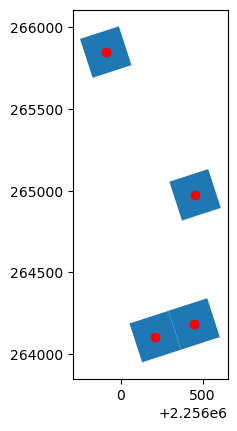

In [178]:
# import geopandas as gpd

# coords = [(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]

# xs = [mg.xcellcenters[r, c] for _, r, c in coords]
# ys = [mg.ycellcenters[r, c] for _, r, c in coords]

# points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys), crs="EPSG:4456") 

# # now plot them
# points.plot(color="red", markersize=40)

fig,ax = plt.subplots()
for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):

    mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax=ax)
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    print(point.crs)
    point.plot(ax=ax, color = 'r')

    point.to_crs(epsg=32618, inplace=True)


In [180]:
point.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [182]:
coords_UTM

[                         geometry
 0  POINT (662172.503 4535164.398),
                          geometry
 0  POINT (662342.196 4534900.004),
                          geometry
 0  POINT (662270.938 4534634.676),
                          geometry
 0  POINT (662343.130 4534659.051)]

c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

                         geometry
0  POINT (662172.503 4535164.398) 0 60 60
                         geometry
0  POINT (662342.196 4534900.004) 0 64 61
                         geometry
0  POINT (662270.938 4534634.676) 0 67 59
                         geometry
0  POINT (662343.130 4534659.051) 0 67 60


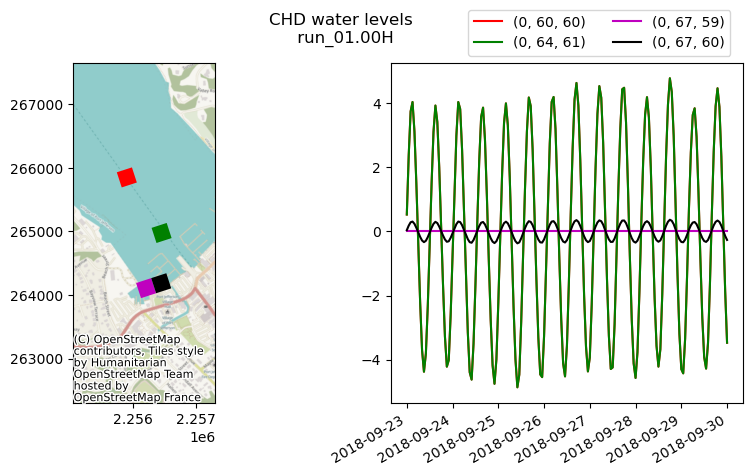

In [183]:
#=================================================================
coords_UTM = []
start_date = pd.to_datetime('2018-09-23')
end_date = pd.to_datetime('2018-09-30')

colors = ['r','g','m','k']
# CHD head Time Series 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):
    # assert the cells are CHDs
    assert ((chd_coastal_obs_cells["lay"] == l) & (chd_coastal_obs_cells["row"] == r) & (chd_coastal_obs_cells["col"] == c)).any()

    # get the coordinated of the center of these cells (in UTM) to be used in the DFLOW-FM observation file to ensure that the heads are the same when coupling
    # ----------------------------------------------
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    point.to_crs(epsg=32618, inplace=True)
    print(point, l,r,c)
    coords_UTM.append(point)


    # plot the map locations
    #-------------------------
    mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(
        ax=ax[0], color=colors[i]
    )
    # get observation name
    obs_name = gwf_obs_cells.loc[
        (gwf_obs_cells['lay'] == 0) &
        (gwf_obs_cells['row'] == r) &
        (gwf_obs_cells['col'] == c), 
        'obs_name'
    ].iloc[0]
    obs_name = obs_name.upper()

    plot_df  = headobs_dict[sim][obs_name][start_date:end_date]
    # save out for liv
    plot_df.to_csv(f'tides/tide_{l,r,c}.txt')
    # plot time series
    plot_df.plot(
        x="Time",
        label=f'{l, r, c}',
        ax=ax[1],
        color=colors[i]
    )
# format time series panel
ax[1].legend(ncol=2,bbox_to_anchor=(0.2, 1),)
# expand map extent by 10% (simple way)
ax[0].margins(0.8)



fig.suptitle(f'CHD water levels \n {sim}')
# add basemap
cx.add_basemap(ax=ax[0], crs=mg_gdf.crs)

## plotting heads from dflow output to verify coupling is good


add modflow observation points to dflow using dflow input ( add to .xyn file). do this manually. 
Don't add all, just spot check one or two locations.

find 

In [71]:
#path  = r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_map.nc"
path  = r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_his.nc" # observation path, data variable = 'water level'
output  = xr.open_dataset(path)
output.waterlevel
#output.waterlevel.sel(station_name='Battery')
#output.waterlevel.isel(stations = 0)

<xarray.DataArray 'waterlevel' (time: 1, stations: 23)> Size: 184B
[23 values with dtype=float64]
Coordinates:
    station_x_coordinate  (stations) float64 184B ...
    station_y_coordinate  (stations) float64 184B ...
    station_name          (stations) |S256 6kB ...
  * time                  (time) datetime64[ns] 8B 2018-09-20
Dimensions without coordinates: stations
Attributes:
    standard_name:  sea_surface_height
    long_name:      water level
    units:          m
    geometry:       station_geom

In [52]:
output.coords
output._coord_names

{'station_name', 'station_x_coordinate', 'station_y_coordinate', 'time'}

In [ ]:
# use facex and facey for coords
dflowdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(output.mesh2d_face_x , output.mesh2d_face_y), crs = 'EPSG:32618')
dflowdf

## Time Series

coastal heads : dflow versions

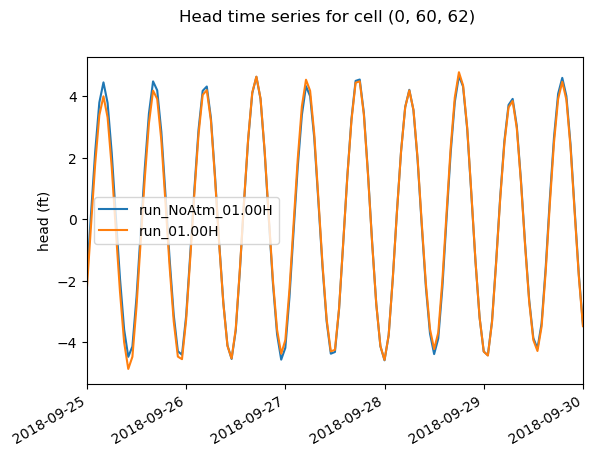

In [72]:
sim_dict_headobs = {}

l,r,c = 0,60,62
obs_name = gwf_obs_cells.loc[((gwf_obs_cells['lay'] == l) & (gwf_obs_cells['row'] == r) & (gwf_obs_cells['col'] == c)), 'obs_name'].iloc[0]
obs_name =obs_name.upper()
obs_name

start_date = pd.Timestamp('2018-09-25 00:00:00')

fig,ax = plt.subplots()
for sim in sim_dirs[0],sim_dirs_atm[0]:
    #Plot Figure
    headobs_dict[sim][obs_name].plot(x = "Time",ax=ax, label = f'{sim}')
ax.legend()
ax.set_xlim(start_date, df.index[-1])
plt.ylabel('head (ft)')
fig.suptitle(f'Head time series for cell {l,r,c}')
plt.show()

# geodataframe of cells to check
cell_location = pd.concat(
    [mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)]])
cell_location.explore(color ="MAGENTA")

..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_02.00H\outputs\hd_obs.csv


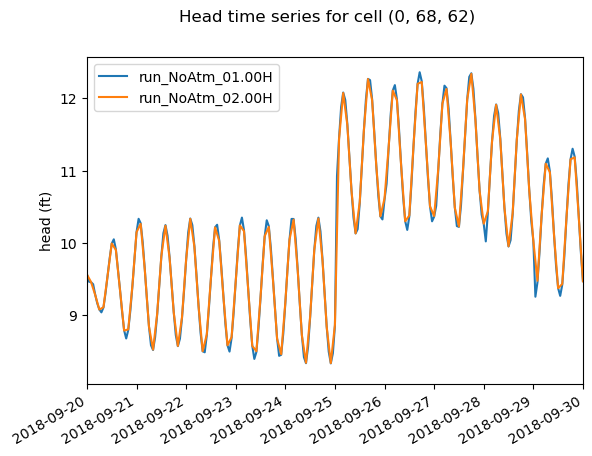

In [73]:
sim_dict_headobs = {}

l,r,c = 0,68,62
obs_name = gwf_obs_cells.loc[((gwf_obs_cells['lay'] == l) & (gwf_obs_cells['row'] == r) & (gwf_obs_cells['col'] == c)), 'obs_name'].iloc[0]
obs_name =obs_name.upper()
obs_name

start_date = pd.Timestamp('2018-09-20 00:00:00')

fig,ax = plt.subplots()
for sim in sim_dirs:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\hd_obs.csv'
    print(obs_path)
    #df = flopy.utils.Mf6Obs(obs_path).get_dataframe()  
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    sim_dict_headobs[sim] = df

    #Plot Figure
    df[obs_name].plot(x = "Time",ax=ax, label = f'{sim}')
ax.legend()
ax.set_xlim(start_date, df.index[-1])
plt.ylabel('head (ft)')
fig.suptitle(f'Head time series for cell {l,r,c}')
plt.show()

# geodataframe of cells to check
cell_location = pd.concat(
    [mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)]])
cell_location.explore(color ="MAGENTA")